Test Accuracy: 0.97
Confusion Matrix:
[[37  0  1]
 [ 0 42  1]
 [ 1  0 38]]


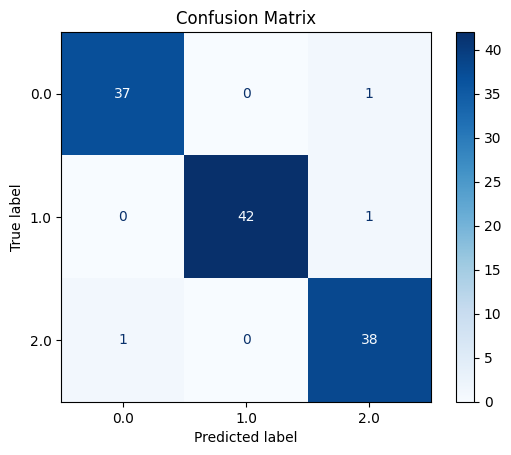

In [1]:
#DATASET -1 BAYES-GAUSSIAN
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class GaussianBayesClassifier:
    def __init__(self):
        self.classes = None
        self.means = None
        self.covariances = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.means = np.zeros((n_classes, n_features))
        self.covariances = np.zeros((n_classes, n_features, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[idx] = np.mean(X_c, axis=0)
            self.covariances[idx] = np.cov(X_c.T)
            self.priors[idx] = len(X_c) / len(X)

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def _predict_single(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            inv_cov = np.linalg.inv(self.covariances[idx])
            diff = x - self.means[idx]
            
            log_likelihood = -0.5 * np.dot(np.dot(diff.T, inv_cov), diff)
            log_likelihood -= 0.5 * np.log(np.linalg.det(self.covariances[idx]))
            log_likelihood -= len(self.classes) * 0.5 * np.log(2 * np.pi)
            
            posterior = prior + log_likelihood
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :2]
    y = data[:, 2]
    return X, y

def plot_decision_regions(classifier, X, y, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = plt.cm.RdYlBu

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx / len(np.unique(y)))],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.title('Gaussian Bayes Classifier Decision Regions')

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-1/train.csv')  #import data here
X_test, y_test = load_data('./team20/Dataset-1/test.csv')

# Create and train the classifier
classifier = GaussianBayesClassifier()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



Test Accuracy: 0.96
Confusion Matrix:
[[37  0  1]
 [ 0 40  3]
 [ 1  0 38]]


/var/folders/z4/9nps5tq53hsf6z3chykw9wrh0000gn/T/ipykernel_90124/3137726502.py:67: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


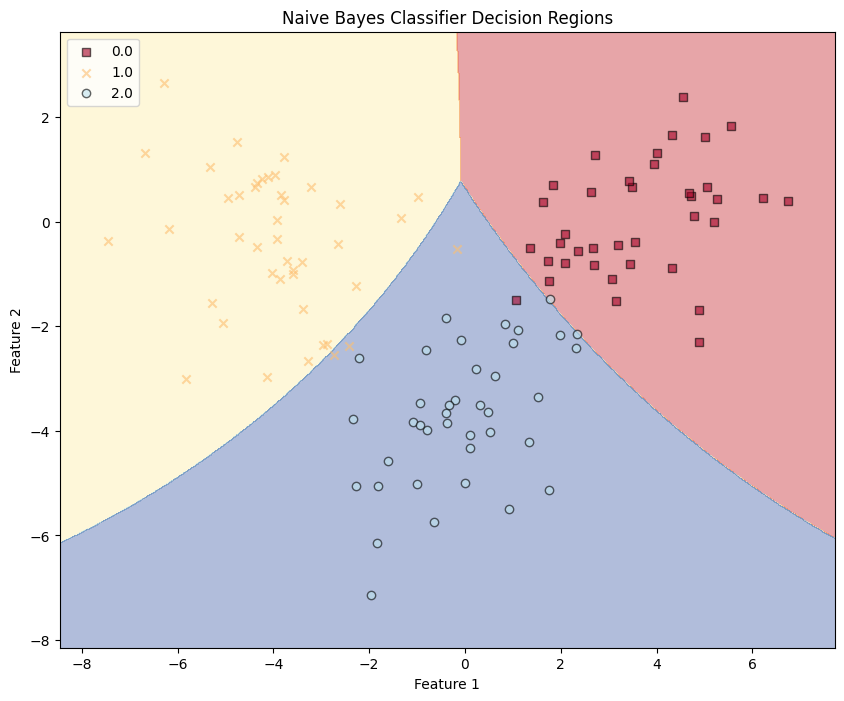

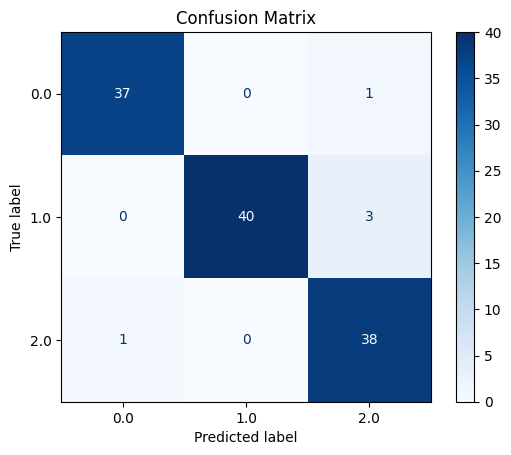

In [2]:
#DATASET 1 NAIVE BAYES
import numpy as np
import matplotlib.pyplot as plt

class NaiveBayesClassifier:
    def __init__(self):
        self.classes = None
        self.means = None
        self.variances = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[idx, :] = X_c.mean(axis=0)
            self.variances[idx, :] = X_c.var(axis=0)
            self.priors[idx] = len(X_c) / len(X)

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def _predict_single(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            posterior = prior
            #calculating posterior prob. fopr each feature
            for feat, mean, var in zip(x, self.means[idx], self.variances[idx]):
                posterior += self._log_gaussian_pdf(feat, mean, var)
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

    def _log_gaussian_pdf(self, x, mean, var):
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x - mean) ** 2) / var

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :2]
    y = data[:, 2]
    return X, y

def plot_decision_regions(classifier, X, y, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = plt.cm.RdYlBu

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx / len(np.unique(y)))],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.title('Naive Bayes Classifier Decision Regions')

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-1/train.csv')  # Assuming you have a train.csv file
X_test, y_test = load_data('./team20/Dataset-1/test.csv')

# Create and train the classifier
classifier = NaiveBayesClassifier()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot decision regions
plt.figure(figsize=(10, 8))
plot_decision_regions(classifier, X_test, y_test)



# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()





Training Data:
 Accuracy (Shared Covariance): 0.9690
 Accuracy (Different Covariances): 0.9690


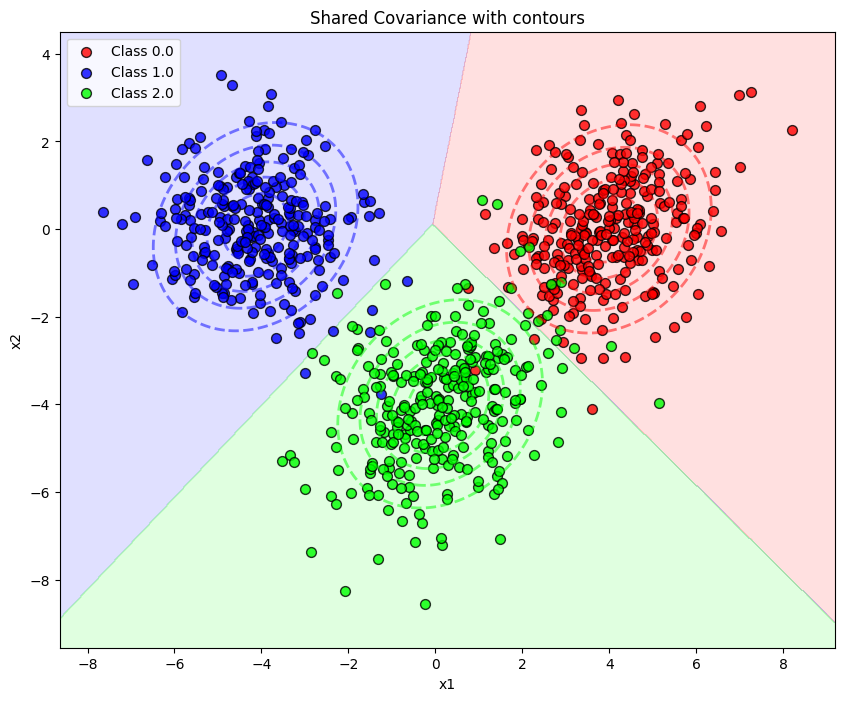

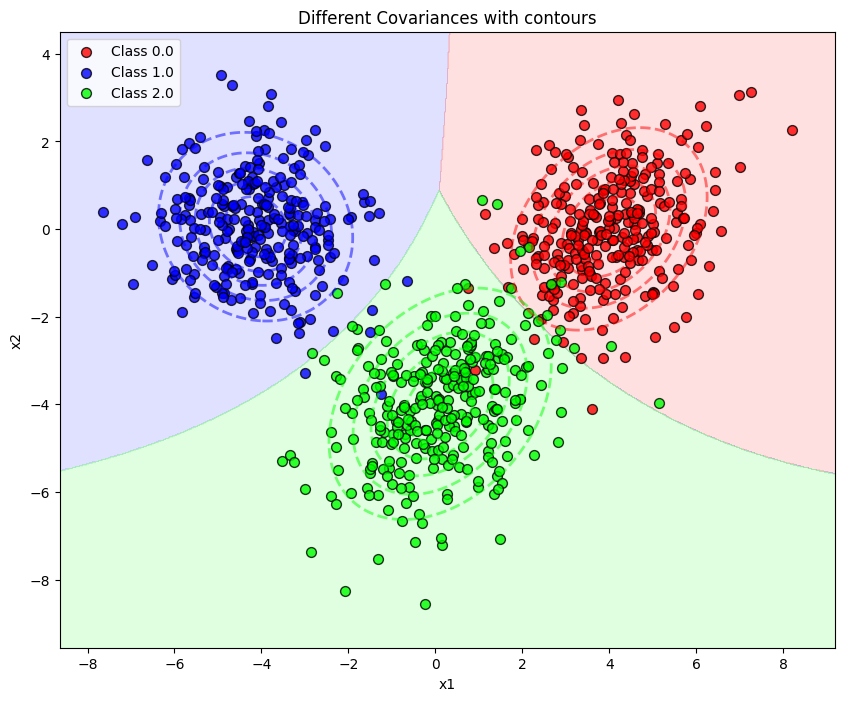

In [11]:

#Bayes Guassian Dataset 1
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap


class GaussianBayesClassifier:
    def __init__(self, shared_covariance=False):
        self.classes = None
        self.means = None
        self.covariances = None
        self.shared_covariance = shared_covariance
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.means = np.zeros((n_classes, n_features))
        self.covariances = np.zeros((n_classes, n_features, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[idx] = np.mean(X_c, axis=0)
            self.covariances[idx] = np.cov(X_c.T)
            self.priors[idx] = len(X_c) / len(X)
        
        if self.shared_covariance:
            # Calculate the average of all covariance matrices
            self.covariances = np.mean(self.covariances, axis=0)

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def _predict_single(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            
            if self.shared_covariance:
                inv_cov = np.linalg.inv(self.covariances)
                cov_det = np.linalg.det(self.covariances)
            else:
                inv_cov = np.linalg.inv(self.covariances[idx])
                cov_det = np.linalg.det(self.covariances[idx])
            
            diff = x - self.means[idx]
            
            log_likelihood = -0.5 * np.dot(np.dot(diff.T, inv_cov), diff)
            log_likelihood -= 0.5 * np.log(cov_det)
            log_likelihood -= len(self.classes) * 0.5 * np.log(2 * np.pi)
            
            posterior = prior + log_likelihood
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

    
    def probability_density(self, X):
        densities = np.zeros((X.shape[0], len(self.classes)))
        for idx, c in enumerate(self.classes):
            if self.shared_covariance:
                cov = self.covariances
            else:
                cov = self.covariances[idx]
            densities[:, idx] = multivariate_normal.pdf(X, mean=self.means[idx], cov=cov)
        return densities
        
    def print_covariance(self):
        if self.covariances is None:
            print("The classifier hasn't been fitted yet. Please call fit() first.")
            return

        if self.shared_covariance:
            print("Shared Covariance Matrix:")
            print(self.covariances)
        else:
            print("Covariance Matrices for each class:")
            for idx, c in enumerate(self.classes):
                print(f"Class {c}:")
                print(self.covariances[idx])
                print()

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :2]
    y = data[:, 2]
    return X, y


#---------
def plot_decision_regions(classifier, X, y, resolution=0.02):
    colors = ['#FF0000', '#0000FF', '#00FF00']  
    complementary_colors = ['#FF9999', '#9999FF', '#99FF99']  
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Create custom colormap for the background
    cmap = ListedColormap(complementary_colors)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Calculate probability densities for level curves
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    densities = classifier.probability_density(X_grid)
    
    # Plot level curves for each class
    for idx in range(len(classifier.classes)):
        Z = densities[:, idx].reshape(xx1.shape)
        levels = np.linspace(Z.min(), Z.max(), 7)
        plt.contour(xx1, xx2, Z, levels=levels, colors=colors[idx], alpha=0.5, linestyles='dashed',linewidths=2)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    edgecolor='black',
                    marker='o',  # Circular marker
                    s=50,  # Marker size
                    label=f'Class {cl:.1f}')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='upper left')
    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
    plt.title('Decision Region Plot with Level Curves')

#--------

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-1/train.csv')
X_test, y_test = load_data('./team20/Dataset-1/train.csv')

# Create and train the classifiers
classifier_shared = GaussianBayesClassifier(shared_covariance=True)
classifier_shared.fit(X_train, y_train)



classifier_different = GaussianBayesClassifier(shared_covariance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Training Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


# Plot results using training data
plt.figure(figsize=(10, 8))

plot_decision_regions(classifier_shared, X_train, y_train,)
plt.title('Shared Covariance with contours')

#plt.savefig("./d1-shared-contours.svg", format="svg", dpi=300)


plt.figure(figsize=(10, 8))
plot_decision_regions(classifier_different, X_train, y_train)
plt.title('Different Covariances with contours')
#plt.savefig("./d1-different-contours.svg", format="svg", dpi=300)



Training Data:
 Accuracy (Shared Covariance): 0.9690
 Accuracy (Different Covariances): 0.9690


Text(0.5, 1.0, 'Different Covariances')

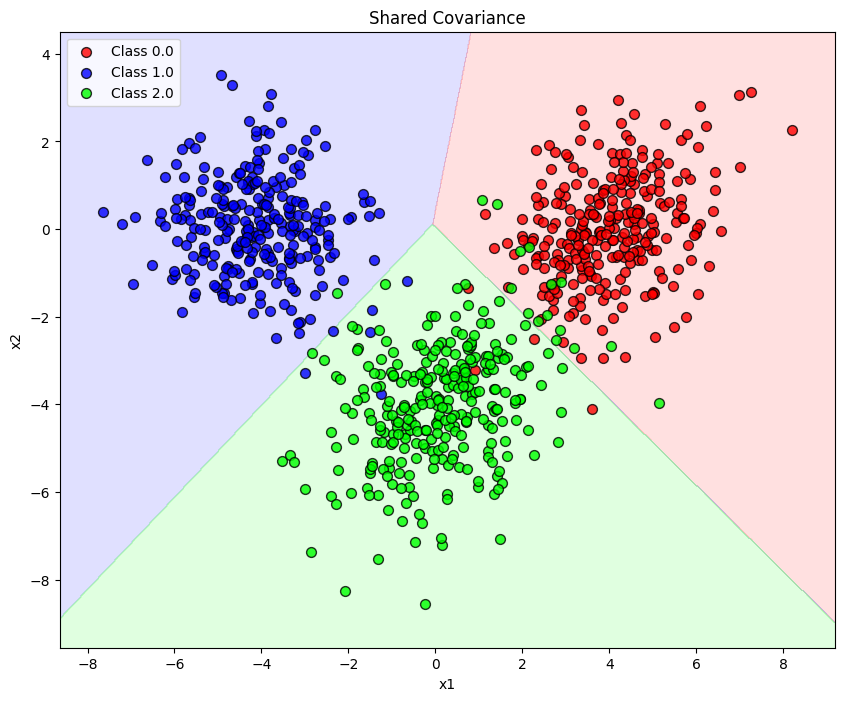

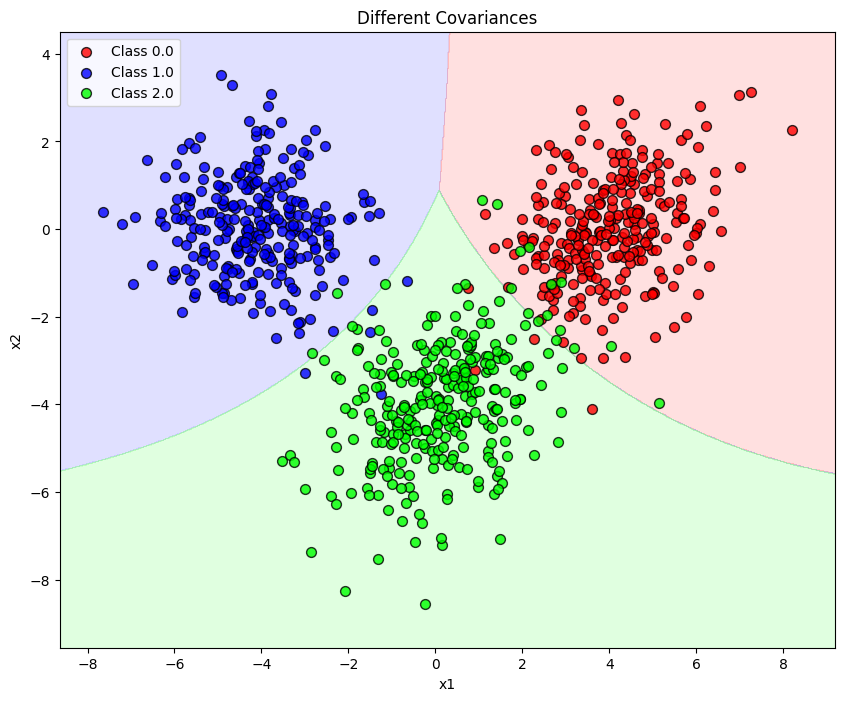

In [15]:

#Bayes Guassian Dataset 1
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap


class GaussianBayesClassifier:
    def __init__(self, shared_covariance=False):
        self.classes = None
        self.means = None
        self.covariances = None
        self.shared_covariance = shared_covariance
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.means = np.zeros((n_classes, n_features))
        self.covariances = np.zeros((n_classes, n_features, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[idx] = np.mean(X_c, axis=0)
            self.covariances[idx] = np.cov(X_c.T)
            self.priors[idx] = len(X_c) / len(X)
        
        if self.shared_covariance:
            # Calculate the average of all covariance matrices
            self.covariances = np.mean(self.covariances, axis=0)

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def _predict_single(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            
            if self.shared_covariance:
                inv_cov = np.linalg.inv(self.covariances)
                cov_det = np.linalg.det(self.covariances)
            else:
                inv_cov = np.linalg.inv(self.covariances[idx])
                cov_det = np.linalg.det(self.covariances[idx])
            
            diff = x - self.means[idx]
            
            log_likelihood = -0.5 * np.dot(np.dot(diff.T, inv_cov), diff)
            log_likelihood -= 0.5 * np.log(cov_det)
            log_likelihood -= len(self.classes) * 0.5 * np.log(2 * np.pi)
            
            posterior = prior + log_likelihood
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

    
    def probability_density(self, X):
        densities = np.zeros((X.shape[0], len(self.classes)))
        for idx, c in enumerate(self.classes):
            if self.shared_covariance:
                cov = self.covariances
            else:
                cov = self.covariances[idx]
            densities[:, idx] = multivariate_normal.pdf(X, mean=self.means[idx], cov=cov)
        return densities
        
    def print_covariance(self):
        if self.covariances is None:
            print("The classifier hasn't been fitted yet. Please call fit() first.")
            return

        if self.shared_covariance:
            print("Shared Covariance Matrix:")
            print(self.covariances)
        else:
            print("Covariance Matrices for each class:")
            for idx, c in enumerate(self.classes):
                print(f"Class {c}:")
                print(self.covariances[idx])
                print()

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :2]
    y = data[:, 2]
    return X, y


#---------
def plot_decision_regions(classifier, X, y, resolution=0.02):
    colors = ['#FF0000', '#0000FF', '#00FF00']  
    complementary_colors = ['#FF9999', '#9999FF', '#99FF99']  
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Create custom colormap for the background
    cmap = ListedColormap(complementary_colors)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Calculate probability densities for level curves
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    densities = classifier.probability_density(X_grid)
    
    # Plot level curves for each class
    # for idx in range(len(classifier.classes)):
    #     Z = densities[:, idx].reshape(xx1.shape)
    #     levels = np.linspace(Z.min(), Z.max(), 7)
    #     plt.contour(xx1, xx2, Z, levels=levels, colors=colors[idx], alpha=0.5, linestyles='dashed',linewidths=2)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    edgecolor='black',
                    marker='o',  # Circular marker
                    s=50,  # Marker size
                    label=f'Class {cl:.1f}')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='upper left')
    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
    plt.title('Decision Region Plot with Level Curves')

#--------

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-1/train.csv')
X_test, y_test = load_data('./team20/Dataset-1/train.csv')

# Create and train the classifiers
classifier_shared = GaussianBayesClassifier(shared_covariance=True)
classifier_shared.fit(X_train, y_train)



classifier_different = GaussianBayesClassifier(shared_covariance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Training Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


# Plot results using training data
plt.figure(figsize=(10, 8))

plot_decision_regions(classifier_shared, X_train, y_train,)
plt.title('Shared Covariance')
#plt.savefig("./d1-shared.svg", format="svg", dpi=300)


plt.figure(figsize=(10, 8))
plot_decision_regions(classifier_different, X_train, y_train)
plt.title('Different Covariances')
#plt.savefig("./d1-different.svg", format="svg", dpi=300)



<Figure size 500x500 with 0 Axes>

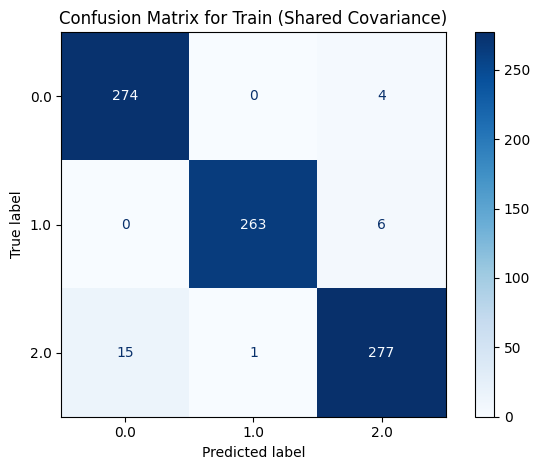

<Figure size 500x500 with 0 Axes>

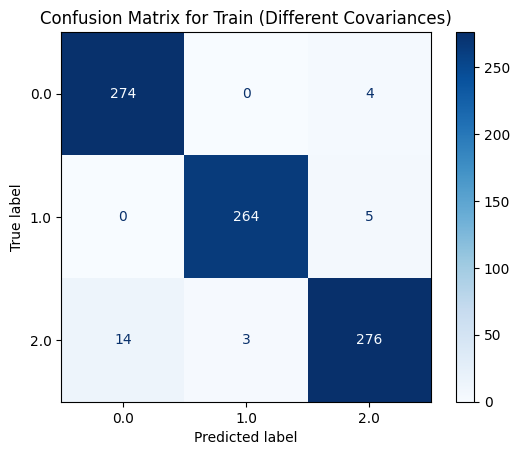

In [19]:
#confusion matrix
#Plot confusion matrix for shared covariance
# plt.subplot(133)

#Confusion matrices
cm_shared = confusion_matrix(y_test, y_pred_shared)
cm_different = confusion_matrix(y_test, y_pred_different)

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_shared, display_labels=classifier_shared.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Train (Shared Covariance)')
plt.tight_layout()
#plt.show()
plt.savefig("./d1-cm-train-shared.svg", format="svg", dpi=300)

# Plot confusion matrix for different covariances
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_different, display_labels=classifier_different.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Train (Different Covariances)')
#plt.show()
plt.savefig("./d1-cm-train-different.svg", format="svg", dpi=300)


Test Data:
 Accuracy (Shared Covariance): 0.9667
 Accuracy (Different Covariances): 0.9750


<Figure size 500x500 with 0 Axes>

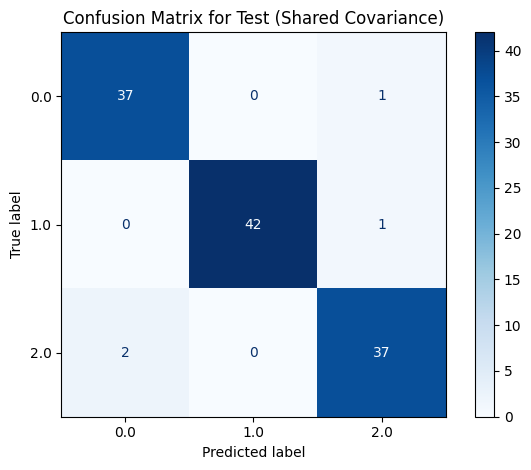

<Figure size 500x500 with 0 Axes>

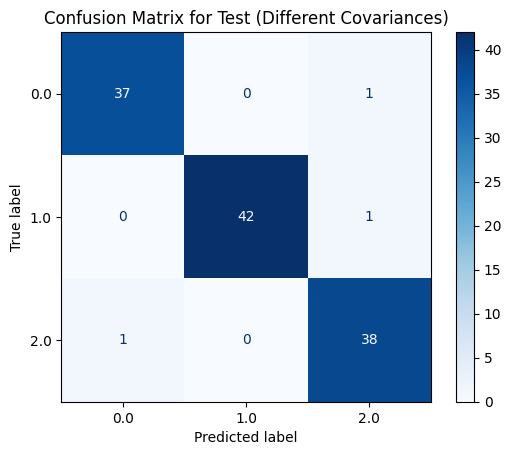

In [21]:
#FOR TESTING DATA

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-1/train.csv')
X_test, y_test = load_data('./team20/Dataset-1/test.csv')

# Create and train the classifiers
classifier_shared = GaussianBayesClassifier(shared_covariance=True)
classifier_shared.fit(X_train, y_train)

classifier_different = GaussianBayesClassifier(shared_covariance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Test Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


#CONFUSION MATRIX
cm_shared = confusion_matrix(y_test, y_pred_shared)
cm_different = confusion_matrix(y_test, y_pred_different)

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_shared, display_labels=classifier_shared.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test (Shared Covariance)')
plt.tight_layout()
#plt.savefig("./d1-cm-test-shared.svg", format="svg", dpi=300)

# Plot confusion matrix for different covariances
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_different, display_labels=classifier_different.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test (Different Covariances)')
#plt.savefig("./d1-cm-test-different.svg", format="svg", dpi=300)



# Plot results using training data
# plt.figure(figsize=(10, 8))
# plot_decision_regions(classifier_shared, X_test, y_test)
# plt.title('Shared Covariance')

# plt.figure(figsize=(10, 8))
# plot_decision_regions(classifier_different, X_test, y_test)
# plt.title('Different Covariances')

Validation Data:
 Accuracy (Shared Covariance): 0.9625
 Accuracy (Different Covariances): 0.9583


<Figure size 500x500 with 0 Axes>

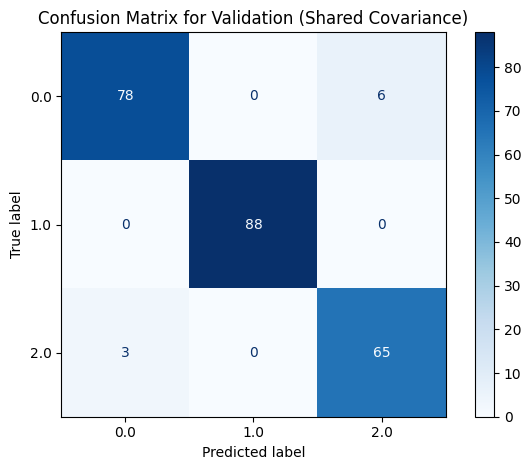

<Figure size 500x500 with 0 Axes>

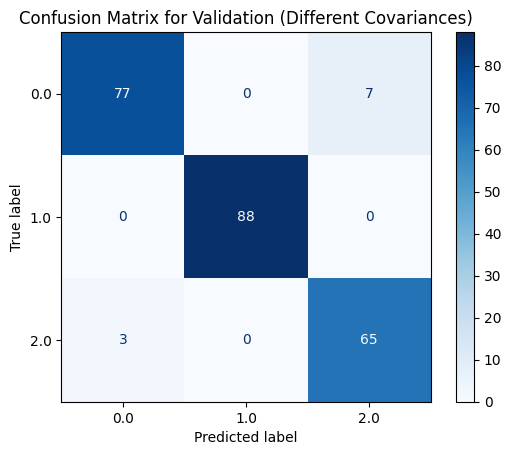

In [25]:
#FOR VALIDATION DATA

# Load and prepare the data
X_train, y_train = load_data('./team20/Dataset-1/train.csv')
X_test, y_test = load_data('./team20/Dataset-1/val.csv')

# Create and train the classifiers
classifier_shared = GaussianBayesClassifier(shared_covariance=True)
classifier_shared.fit(X_train, y_train)

classifier_different = GaussianBayesClassifier(shared_covariance=False)
classifier_different.fit(X_train, y_train)

# Make predictions
y_pred_shared = classifier_shared.predict(X_test)
y_pred_different = classifier_different.predict(X_test)

# Calculate accuracies
accuracy_shared = np.mean(y_pred_shared == y_test)
accuracy_different = np.mean(y_pred_different == y_test)

print('Validation Data:')
print(f" Accuracy (Shared Covariance): {accuracy_shared:.4f}")
print(f" Accuracy (Different Covariances): {accuracy_different:.4f}")


#CONFUSION MATRIX
cm_shared = confusion_matrix(y_test, y_pred_shared)
cm_different = confusion_matrix(y_test, y_pred_different)

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_shared, display_labels=classifier_shared.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation (Shared Covariance)')
plt.tight_layout()
plt.savefig("./d1-cm-val-shared.svg", format="svg", dpi=300)

# Plot confusion matrix for different covariances
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_different, display_labels=classifier_different.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation (Different Covariances)')
plt.savefig("./d1-cm-val-different.svg", format="svg", dpi=300)


# Plot results using training data
# plt.figure(figsize=(10, 8))
# plot_decision_regions(classifier_shared, X_test, y_test)
# plt.title('Shared Covariance')

# plt.figure(figsize=(10, 8))
# plot_decision_regions(classifier_different, X_test, y_test)
# plt.title('Different Covariances')